In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import operator
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import minkowski_distance, distance
from sklearn.metrics import pairwise

!pip install imdbpy
from imdb import IMDb
ia = IMDb()

     |████████████████████████████████| 298 kB 895 kB/s 


2021-12-05 10:27:07,247 INFO [imdbpy.parser.http.piculet] /opt/conda/lib/python3.7/site-packages/imdb/parser/http/piculet.py:262: using lxml


In [2]:
# kdramas = pd.read_csv("../input/ii-completing-dataset-with-imdbpy/kdrama_v1.csv")
kdramas = pd.read_csv("../input/imdb-korea/kdrama_v1.csv")
kdramas.shape
# kdramas.head()

(1234, 11)

In [3]:
kdramas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       1234 non-null   object 
 1   year        1234 non-null   object 
 2   movie_id    1216 non-null   float64
 3   title_new   1216 non-null   object 
 4   country     1162 non-null   object 
 5   cast_IDs    1184 non-null   object 
 6   cast_names  1184 non-null   object 
 7   genres      1191 non-null   object 
 8   rating      1067 non-null   float64
 9   year_new    1199 non-null   float64
 10  type        1199 non-null   object 
dtypes: float64(3), object(8)
memory usage: 106.2+ KB


In [4]:
kdramas.shape

(1234, 11)

In [5]:
kdramas['movie_id'] = kdramas['movie_id'].fillna(-1).astype(int)
kdramas['year_new'] = kdramas['year_new'].fillna(-1).astype(int)

## I. Recheck

In [6]:
# Remove entries with non-korean origin
kdramas  = kdramas[kdramas['country'] == 'kr']

# Remove entries without casts
kdramas = kdramas[kdramas['cast_names'].notnull()]

# Limit only tv series
kdramas = kdramas[kdramas['type'] == 'tv series']

In [7]:
kdramas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010 entries, 0 to 1233
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       1010 non-null   object 
 1   year        1010 non-null   object 
 2   movie_id    1010 non-null   int64  
 3   title_new   1010 non-null   object 
 4   country     1010 non-null   object 
 5   cast_IDs    1010 non-null   object 
 6   cast_names  1010 non-null   object 
 7   genres      1006 non-null   object 
 8   rating      935 non-null    float64
 9   year_new    1010 non-null   int64  
 10  type        1010 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 94.7+ KB


In [8]:
genres = []
actorFeatures = {}
kdramas['genres'] = kdramas['genres'].fillna('unk')
# Removed unfound /unrelated genres
kdramas = kdramas[(~kdramas['genres'].str.contains("Reality-TV")) & (~kdramas['genres'].str.contains("unk"))]

for idx,row in kdramas.iterrows():
    
    # collecting genres
    gr = row['genres']
    for g in gr.split(','):
        if g not in genres:
            genres.append(g)
    
    # making new dataset: actor ID & Names
    actor_ids = row['cast_IDs'].split(',')
    actor_names = row['cast_names'].split(',')
    
    for i in range(len(actor_ids)):
        if i < 10 and actor_ids[i] not in actorFeatures:
            actorFeatures[actor_ids[i]] = actor_names[i]
            
actorFeatures = pd.DataFrame.from_dict(actorFeatures, orient='index').reset_index()
actorFeatures.columns = ['actor_ID', 'actor_name']
actorFeatures['actor_ID'] = actorFeatures['actor_ID'].astype(int)

In [9]:
# Make a dictionary to store averaged rating per genre
genres_dict = {}
for genre in genres:
    genres_dict[genre] = []
    
rating_filled = kdramas[kdramas.rating.notnull()]

for i, dr in rating_filled.iterrows():
    gr = dr['genres']
    for g in gr.split(','):
        genres_dict[g].append(dr['rating'])
        
for k in genres_dict.keys():
    genres_dict[k] = np.average(genres_dict[k])
    
# Fill unknown rating per genre
for i, d in kdramas.iterrows():
    if np.isnan(d['rating']):
        genres1 = d['genres'].split(',')
        genres_rating = []
        for g in genres1:
            genres_rating.append(genres_dict[g])
        kdramas.loc[i, 'rating'] = np.average(genres_rating)

In [10]:
cols = ['movie_id', 'title_new', 'cast_IDs', 'cast_names', 'genres', 'rating', 'year_new']
kdramas = kdramas[cols]
kdramas.columns=['movie_id', 'title', 'cast_IDs', 'cast_names', 'genres', 'rating','year']
# getting rid of duplicates
kdramas = kdramas.drop_duplicates(subset = 'movie_id')

In [11]:
kdramas.head()

,movie_id,title,cast_IDs,cast_names,genres,rating,year
0,8199972,100 Days My Prince,"6765553,2305471,1443295,3498542,9170918,789033...","Kyung-soo Do,Nam Ji-Hyun,Jo Sung-ha,Jo Han-chu...","Action,Comedy,History,Romance",7.7,2018
1,5476252,12 Years Promise,"10213650,1452474,1224530,0046276,6857341,37533...","Im Ji-Hyun,So-yeon Lee,Min Namkoong,Chong-ok B...","Comedy,Drama,Romance",7.4,2014
2,12846096,18 Again,"6327190,2341244,9946376,7591921,11794543,69165...","Ha-neul Kim,Yoon Sang-Hyun,Lee Do-Hyun,No Jeon...","Comedy,Fantasy,Romance",8.2,2020
3,12015466,365: Repeat the Year,"3789806,2305471,1790874,11794543,12016813,1052...","Lee Joon-hyuk,Nam Ji-Hyun,Kim Ji-Soo,Ryeoun,Le...","Crime,Drama,Fantasy,Mystery,Thriller",8.1,2020
4,4449190,The Legendary Witch,"1623740,5754288,1085809,5204923,2291768,218888...","Ji-hye Han,Yeon-Soo Ha,Du-shim Ko,Hyun-Kyung O...","Drama,Romance",7.6,2014


In [12]:
kdramas.shape

(994, 7)

In [13]:
actorFeatures.head()

,actor_ID,actor_name
0,6765553,Kyung-soo Do
1,2305471,Nam Ji-Hyun
2,1443295,Jo Sung-ha
3,3498542,Jo Han-chul
4,9170918,Kim Seon-Ho


In [14]:
kdramas['num_cast'] = kdramas['cast_IDs'].apply(lambda z: len(z.split(',')))

<AxesSubplot:ylabel='Frequency'>

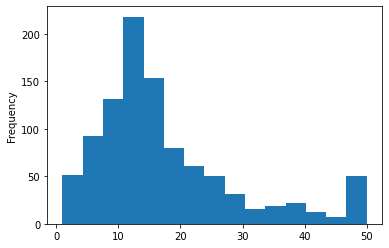

In [15]:
kdramas['num_cast'].plot(kind='hist', bins = 15)

## II. Create New Features

In [16]:
actorFeatures = actorFeatures.set_index('actor_ID')

## Assigning new Features per Genres
for g in genres:
    
    actorFeatures[g + "_count"] = 0
    actorFeatures[g + "_totalRating"] = 0
    actorFeatures[g + "_avgRating"] = 0
    
actorFeatures['total_drama'] = 0
actorFeatures['total_rating'] = 0
actorFeatures['recency'] = 0
actorFeatures['leadTotal'] = 0
actorFeatures['supTotal'] = 0
actorFeatures['supWt'] = 0
actorFeatures['leadWt'] = 0

In [17]:
cr_year = 2021
# Iterating through each dramas
for i, d in kdramas.iterrows():

    cast_IDs = d['cast_IDs'].split(',')
    grs = d['genres'].split(',')
    rating = d['rating']
    
    diff_yr = cr_year - d['year'] + 1

    #Iterating through each cast member
    for i in range(len(cast_IDs)):
        if i < 10: #Only for first 15 listed actors per drama
            id = int(cast_IDs[i])
            # assigning total drama
            actorFeatures.loc[id, 'total_drama'] += 1
            # assigning sum of ratings
            actorFeatures.loc[id, 'total_rating'] += rating
            actorFeatures.loc[id, 'recency'] += diff_yr

            # Defining weights for leads
            if i >= 0 and i <= 2:
                actorFeatures.loc[id, 'leadWt'] += 2
            else:
                actorFeatures.loc[id, 'supWt'] += 1

            for g in grs:
                # assigning genre count
                actorFeatures.loc[id, g + '_count'] += 1
                # assigning genre rating sum
                actorFeatures.loc[id, g + '_totalRating'] += rating

In [18]:
# Get average recency per actor
actorFeatures['recency_avg']= actorFeatures['recency']/actorFeatures['total_drama']
# Get average rating per genre
for g in genres:
    actorFeatures[g + "_avgRating"] = actorFeatures[g + "_totalRating"]/actorFeatures[g + "_count"]

In [19]:
# Select Columns
cols_avgRating = [g + '_avgRating' for g in genres] 
cols_posWt = ['leadWt', 'supWt']

for c in cols_posWt:
    actorFeatures[c] = actorFeatures[c]/ actorFeatures['total_drama']
    
# Scale variables
scaler = MinMaxScaler()
actorFeatures[cols_avgRating] = scaler.fit_transform(actorFeatures[cols_avgRating])
actorFeatures[cols_posWt] = scaler.fit_transform(actorFeatures[cols_posWt])

# Fill NaNs
actorFeatures = actorFeatures.fillna(0)

## III.A. Find Closest Actors

In [20]:
# Define what features to use
cols_all =  cols_avgRating + ['recency_avg'] + cols_posWt

# Calculate Cosine Similarity among actors
sim = pairwise.cosine_similarity(actorFeatures[cols_all])

In [21]:
K = 3 #define how many actors are closest to
for selectActor in ['Lee Min-Ho', 'Suzy']:

    print("Actor Name:", selectActor)
    print("With Cosine Similarity")

    ## Cosine Similarity
    # Get row number of selected Actor
    row_actor = actorFeatures.index.get_loc(actorFeatures.loc[actorFeatures['actor_name'].str.contains(selectActor)].index[0])
    # Get K closest actorFeatures (returned row numbers)
    row_cands = list(reversed(np.argsort(sim[row_actor])[-K-1:-1]))
    # Show K closest actorFeatures
    for i in range(K):
        print(i+1, actorFeatures.iloc[row_cands[i], 0], np.round(sim[row_actor][row_cands[i]],4))

    ## K Nearest Neighbors
    print("")
    id_ = actorFeatures.loc[actorFeatures['actor_name'].str.contains(selectActor)].index[0]
    print("With K-Nearest Neighbors")

    actor_vec = actorFeatures.loc[actorFeatures.index == id_, cols_all].values.reshape(1, -1) #Get the actor vector
    recs = actorFeatures.drop(actorFeatures[actorFeatures.index == id_].index, axis = 0)[cols_all] #Get the rest vectors

    # Define model, using K with Euclidean distance
    knn = NearestNeighbors(n_neighbors=K, p=2)
    knn.fit(recs)

    # Return closest actorFeatures
    idxs = knn.kneighbors(actor_vec, return_distance=True)
    for i in range(K):
        print(i+1, actorFeatures.iloc[idxs[1][0][i]]['actor_name'], np.round(idxs[0][0][i],4))
    print("\n")

Actor Name: Lee Min-Ho
With Cosine Similarity
1 Kim Tae-hee 0.9984
2 Shin Min-a 0.998
3 Lee Joon-Gi 0.9979

With K-Nearest Neighbors
1 Lee Joon-Gi 0.6342
2 Go Ara 0.8191
3 Yoon Jung Shin 0.8658


Actor Name: Suzy
With Cosine Similarity
1 Seong-rok Sin 0.994
2 Jun Ji-hyun 0.9872
3 Park Shin-Hye 0.985

With K-Nearest Neighbors
1 Seong-rok Sin 0.9039
2 Kang-woo Kim 1.1988
3 Sung-Jae Lee 1.2625


